# Lab Notebook 15 - Clustering methods

In this notebook, we will learn how to write a **k-means++ clustering** code from scratch. We will test this code on two different data sets: one with spherically shaped clusters, and another with irregularly shaped clusters. Next, we will use **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)** on the same data sets, and determine which ML method is better.

## Step 1

Import the appropriate packages and, optionally, set your matplotlib.rc parameters.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = [10, 8] 

## Step 2

Here is our first dataset. Make a scatter plot of the data points.

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate (approximately circular) data:
centers1 = 4
xvals1, true_labels1 = make_blobs(n_samples=100, centers=centers1, random_state=30,cluster_std=0.3)
xvals1 = StandardScaler().fit_transform(xvals1)

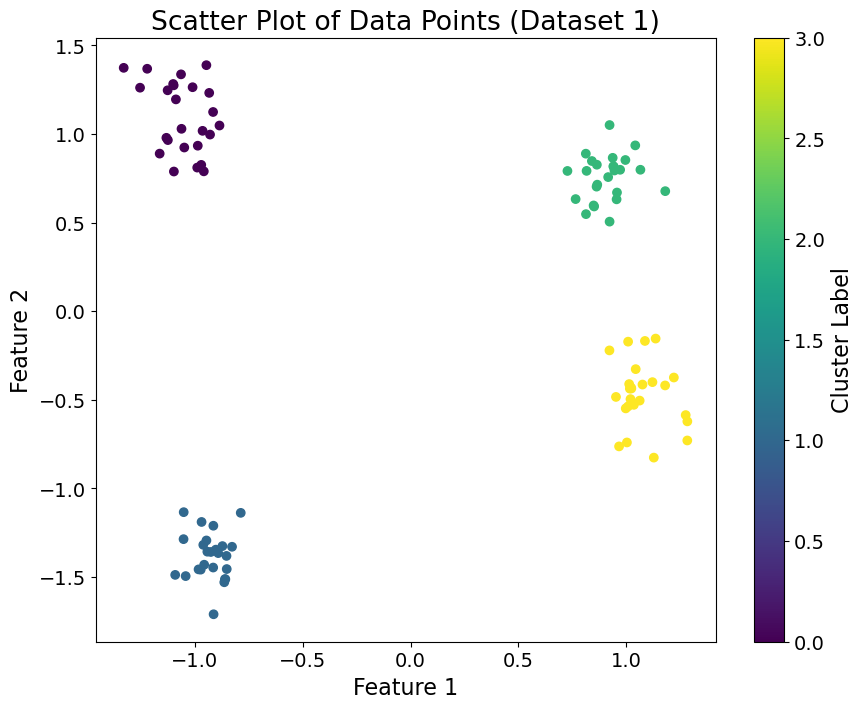

In [3]:
plt.scatter(xvals1[:, 0], xvals1[:, 1], c=true_labels1)
plt.title('Scatter Plot of Data Points (Dataset 1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

Here is our second dataset. Again make a scatter plot of the data.

In [4]:
# Generate (irregular) data:
centers2 = [[1, 0], [-1, -1], [1.5, -1.5]]
ncenters2 = 3
xvals2, true_labels2 = make_blobs(n_samples=100, centers=centers2, cluster_std=[0.4, 0.3, 0.85], random_state=0)

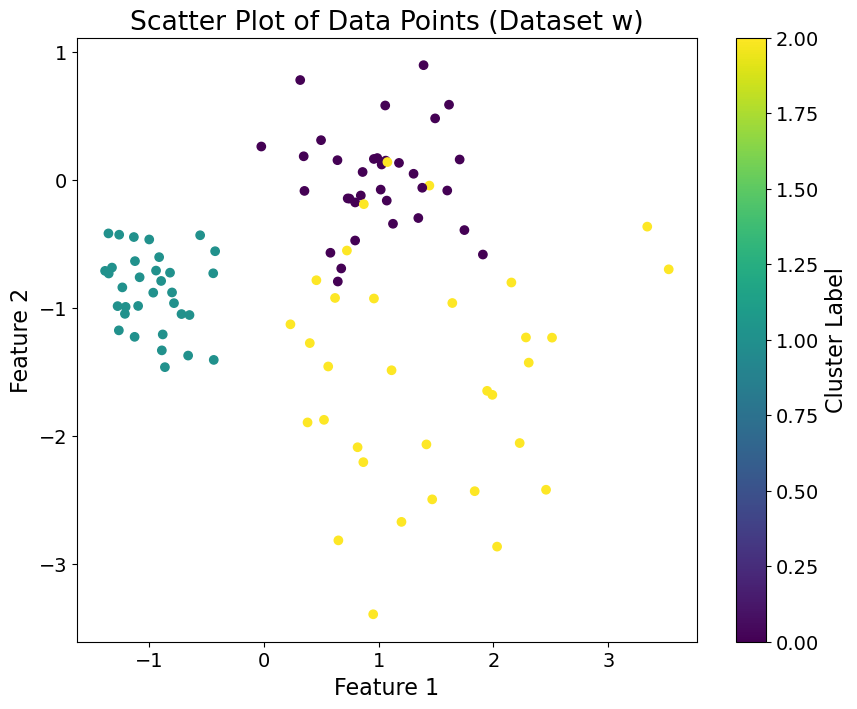

In [5]:
plt.scatter(xvals2[:, 0], xvals2[:, 1], c=true_labels2)
plt.title('Scatter Plot of Data Points (Dataset w)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

## Step 3

Now we will write our k-means++ clustering algorithm. 

First, define a function called "euclidean" that intakes a point and a dataset of points, and returns the euclidean distance.
The point has dimensions (m,), the data has dimensions (n,m), and output will be of size (n,). You already wrote such a function for the knn algorithm in lab 3, feel free to import your code.

In [6]:
def euclidean(point, dataset):
    squared_diff = np.square(dataset - point)

    sum_squared_diff = np.sum(squared_diff, axis=1)
    return np.sqrt(sum_squared_diff)

def euclidean(point, dataset):
    squared_diff = np.square(dataset - point)
    print("Squared Differences Shape:", squared_diff.shape)
    sum_squared_diff = np.sum(squared_diff, axis=1)
    return np.sqrt(sum_squared_diff)

def euclidean(point, dataset):
    squared_diff = np.square(dataset - point)
    if len(squared_diff.shape) == 1:
        squared_diff = squared_diff.reshape(1, -1)
    sum_squared_diff = np.sum(squared_diff, axis=1)
    return np.sqrt(sum_squared_diff)

Next, define the class "KMeans". Within this class, we have the following functions:

1. **\_\_init\_\_**, which has inputs self, n_clusters, and max_iter. You can set default values for n_clusters and max_iter if you wish. Let self.n_clusters = n_clusters and self.max_iter = max_iter.

2. **fit**, which has inputs self and X_train. This is the core of the kmeans algorithm.

3. **evaluate**, which intakes self and X. This function will evaluate the distance between a set of points and the centroids for which weâ€™ve optimized our training set. This method returns classification labels, i.e. the index of the centroid to which each data point belongs. 

init and fit are already provided. You need to complete a few lines in **evaluate**

In [7]:
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
import random

class KMeans:
    def __init__(self, n_clusters=8, max_iter=300, random_state=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        
    def fit(self, X_train):
        # We provide the following code, also called the "k-means++" method, to initialize the centroids. 
        # A random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first point
        
        # Pick a random point from train data for first centroid
        np.random.seed(self.random_state)
        self.centroids = [random.choice(X_train)]
        # Set the remaining initial guesses
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            np.random.seed(self.random_state)
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
            
        # end of initialization
        
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        
        
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0 
        # initialize a counter for the number of iterations
        prev_centroids = None 
        #intialize an array prev_centroids = None
        # while centroids are changing and max_iter is not exceeded:
            
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # initialize and empty array sorted_points
            sorted_points = [[] for _ in range(self.n_clusters)]
            
            # loop over training set, compute distances data-centroids, find closest centroid for each data point, 
            # append data point to list belonging to that centroid            
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
                
            # Store current centroids in previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            
            # Restore previous centroid if new one has no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            # Increment counter
            iteration += 1
            
    def evaluate(self, X):
        #initialize an empty list for the indices of the centroids
        centroid_idxs = []
        #loop over all examples
        for x in X:
            # compute distances to all centroids
            dists_cent = [euclidean(x, centroid) for centroid in self.centroids]
           
            # find the clostest centroid for each data point
            closest_centroid_idx = np.argmin(dists_cent)
           
            # append index to list of indices
            centroid_idxs.append(closest_centroid_idx)
            
        # return centroid indices
        return centroid_idxs

## Step 4

Test the code on dataset 1. Make a scatter plot of the data, color the data by classification label, and draw the positions of the centroids in a different symbol and color.

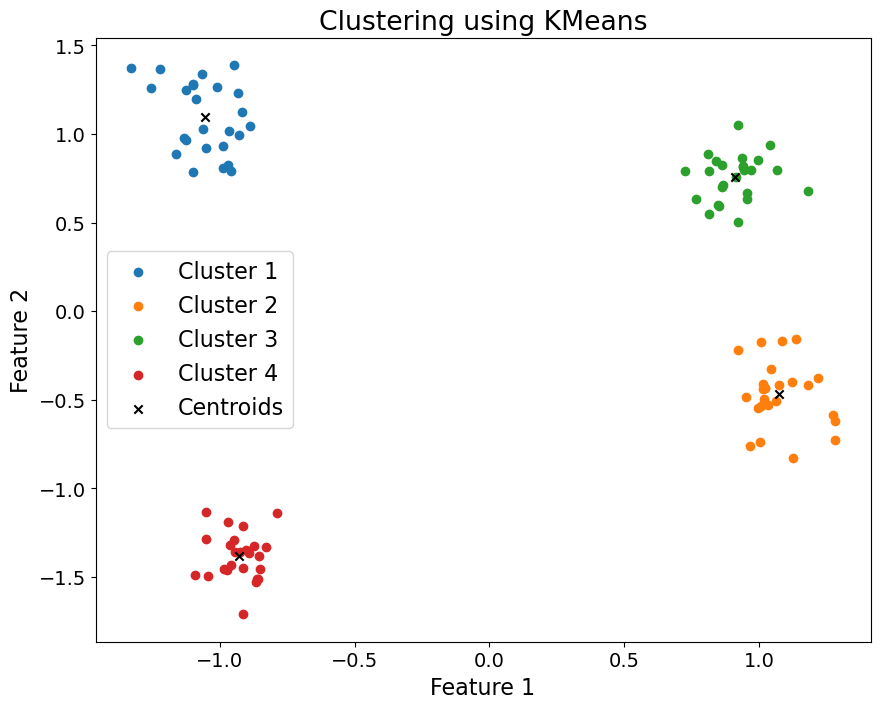

In [8]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(xvals1)
pred = kmeans.evaluate(xvals1)


for i in range(centers1):
    cluster = np.array([xvals1[j] for j in range(len(xvals1)) if pred[j] == i])
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
plt.scatter(np.array(kmeans.centroids)[:, 0], np.array(kmeans.centroids)[:, 1], color='black', marker='x', label='Centroids')
plt.title('Clustering using KMeans')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Repeat the above on dataset 2.

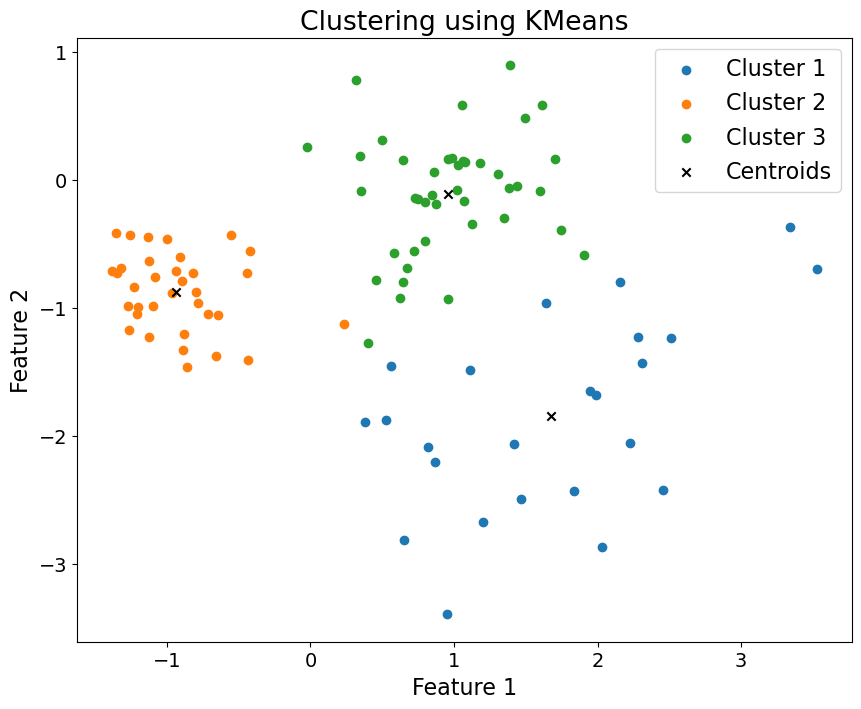

In [9]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(xvals2)
pred = kmeans.evaluate(xvals2)


for i in range(ncenters2):
    cluster = np.array([xvals2[j] for j in range(len(xvals2)) if pred[j] == i])
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
plt.scatter(np.array(kmeans.centroids)[:, 0], np.array(kmeans.centroids)[:, 1], color='black', marker='x', label='Centroids')
plt.title('Clustering using KMeans')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## Step 5

Hopefully, your k-means+ code worked to find the centroids of Datasets 1 and 2. However, in real life your datasets will likely be more complicated. For instance, see the following "smiley face" data:

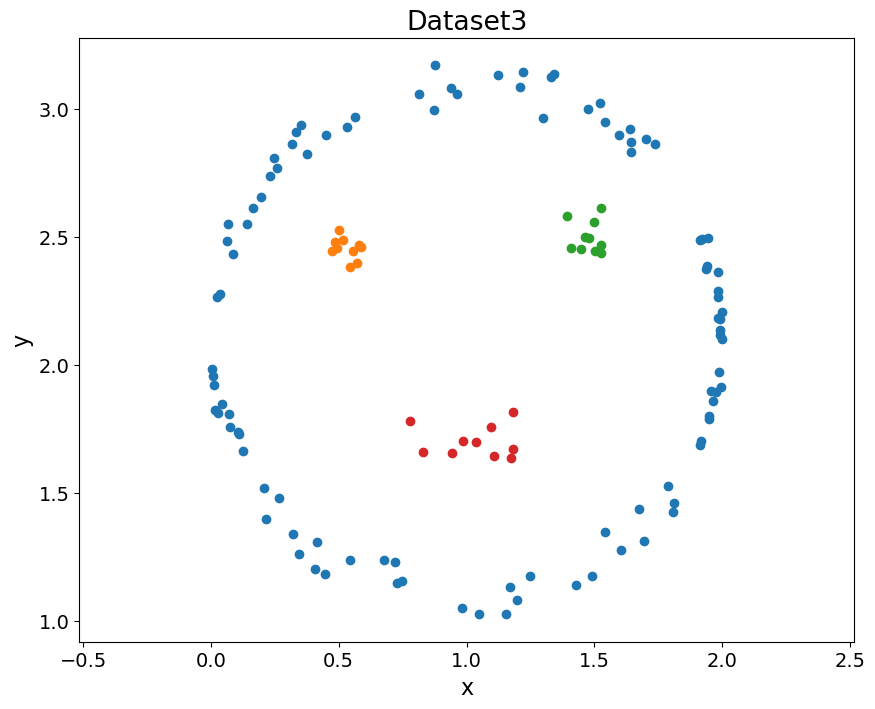

In [10]:
from math import pi, cos, sin
import random
np.random.seed(10)
def point(h, k, r):
    theta = random.random() * 2 * pi
    return h + cos(theta) * r, k + sin(theta) * r + 0.2*random.random()

# Generate points:
xy = [point(1,2,1) for _ in range(100)]

X1, y1 = make_blobs(n_samples=10, centers=[(0.5,2.5)],
                       cluster_std=0.05, random_state=1)

X2, y2 = make_blobs(n_samples=10, centers=[(1.5,2.5)],
                       cluster_std=0.05, random_state=2)

X3, y3 = make_blobs(n_samples=10, centers=[(1,1.7)],
                       cluster_std=0.05, random_state=2)

X3_stretch = np.array([X3[:,0]*3, X3[:,1]]) #make the mouth :) 


# Plot:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(*zip(*xy))
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.scatter(X3_stretch.T[:,0]-1.9,X3_stretch.T[:,1])

plt.title("Dataset3")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Try running your code on the "smiley face" dataset. Does your code accurately predict the centroids? You will need to use the following line of code (or something similar) to turn the smiley face data arrays into one array, "xvals3":

    xvals3 = np.vstack([xy,X1,X2,np.array([X3_stretch.T[:,0]-1.9,X3_stretch.T[:,1]]).T])

In [11]:
xvals3 = np.vstack([xy,X1,X2,np.array([X3_stretch.T[:,0]-1.9,X3_stretch.T[:,1]]).T])

C:\Users\antho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\antho\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[2, 1, 2, 2, 2, 2, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 3, 1, 1, 3, 0, 2, 0, 0, 0, 1, 1, 2, 2, 0, 3, 1, 1, 1, 0, 0, 2, 2, 3, 0, 0, 0, 3, 0, 0, 2, 1, 2, 2, 3, 2, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 3, 3, 3, 0, 3, 3, 1, 0, 1, 1, 3, 3, 2, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 1, 1, 0, 0, 3, 2, 1, 1, 2, 1, 3, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


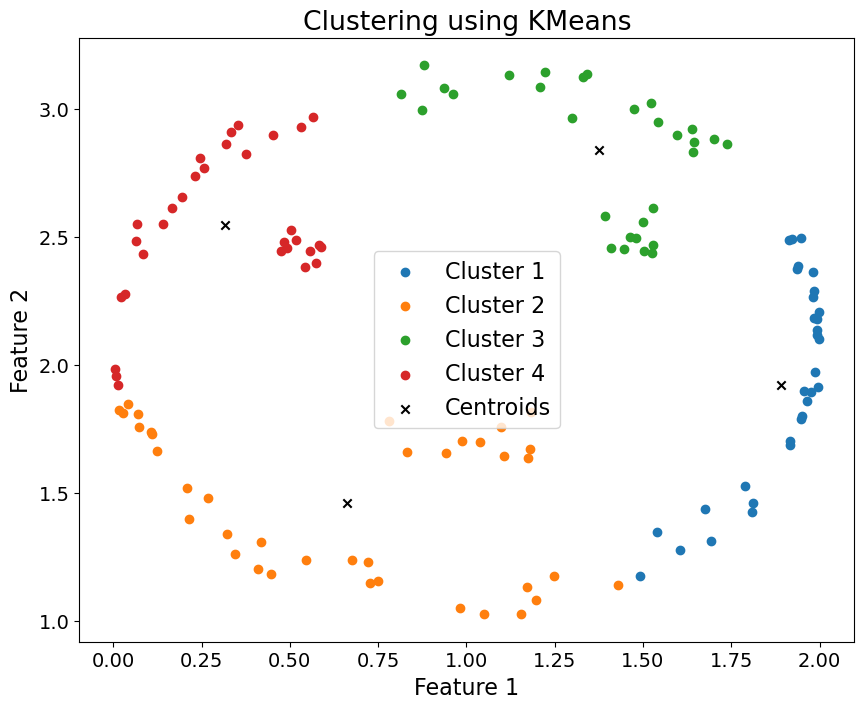

In [12]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(xvals3)
pred = kmeans.evaluate(xvals3)
print(pred)

for i in range(4):
    cluster = np.array([xvals3[j] for j in range(len(xvals3)) if pred[j] == i])
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
plt.scatter(np.array(kmeans.centroids)[:, 0], np.array(kmeans.centroids)[:, 1], color='black', marker='x', label='Centroids')
plt.title('Clustering using KMeans')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Did the k-means++ code accurately predict the centroids? Why or why not?

#### No it didn't, because the clusters are not well-defined and have irregular shapes.

## Step 6

Another method we can use is called **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**. For a a set of points in space, this algorithm groups the points that are closely packed together, and identifies points that lie in low-density regions as outliers.

From sklearn.cluster, import "DBSCAN". We will be using the "smiley face" data to test this method. Plot the data colored by cluster label. How many clusters does DBSCAN find? How does the answer depend on the parameter **eps**?

Number of Clusters: 6


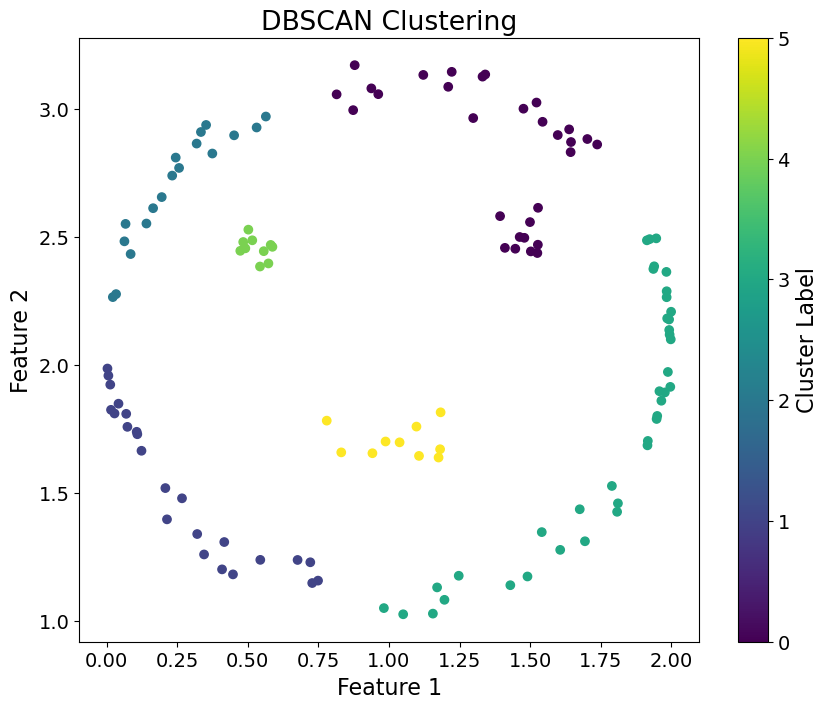

In [13]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.25)
dbscan.fit(xvals3)

labels = dbscan.labels_


n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of Clusters:', n_clusters)


plt.scatter(xvals3[:, 0], xvals3[:, 1], c=labels)
plt.title("DBSCAN Clustering")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [14]:
ra=np.arange(0.01,1,0.04)
dict={}
for eps in ra:
    dbscan_model=DBSCAN(eps=eps)
    dbscan_labels=dbscan_model.fit_predict(xvals3)
    num_clusters=len(set(dbscan_labels))-(1 if -1 in dbscan_labels else 0)
    dict[eps]=num_clusters
print(dict)

{0.01: 0, 0.05: 1, 0.09: 6, 0.13: 10, 0.17: 12, 0.21000000000000002: 9, 0.25: 6, 0.29000000000000004: 3, 0.33: 2, 0.37: 2, 0.41000000000000003: 2, 0.45: 1, 0.49: 1, 0.53: 1, 0.5700000000000001: 1, 0.61: 1, 0.65: 1, 0.6900000000000001: 1, 0.73: 1, 0.77: 1, 0.81: 1, 0.85: 1, 0.89: 1, 0.93: 1, 0.97: 1}


#### Eps changes the number of clusters, as it is the max distance between two samples for one to be considered in the neighborhood of the other. Larger values of eps result in more points being grouped into a single cluster, while smaller values can lead to more clusters and potentially classify some points as noise. From eps=0.01 to eps=0.17 the amount of clusters rises, and then it lowers, and converges at 1 cluster from eps=0.45 and up.